## Custom Model and Dataset Example

This example demonstrates how to create GNNShap explanations for a custom model and dataset.

**__Please make sure to run this notebook from the project's root directory.__**

## Model and Training

In [1]:
!export CC=gcc-9
!export CXX=g++-9

In [46]:
import matplotlib.pyplot as plt


In [50]:
# Source: https://raw.githubusercontent.com/pyg-team/pytorch_geometric/master/examples/gcn.py

import torch
import torch.nn.functional as F
import os

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.logging import init_wandb, log
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
import tqdm


if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# dataset = Planetoid(name='Cora', root='./data/Planetoid', transform=T.NormalizeFeatures())
data = data = torch.load(os.path.join('data_full.pt'))
data = data.to(device)
# data = dataset[0].to(device)

class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data, edge_weight=None):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index, edge_weight=None))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_weight=None)
        return F.log_softmax(x, dim=1)


class GAT(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, 8, heads=8, dropout=0.6)
        self.conv2 = GATConv(8 * 8, num_classes, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)



model = GAT(num_features=data.num_features, num_classes=3).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


def train():    
    model.train()
    best_val_loss = float('inf')
    for epoch in range(2):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), 'best_model.pt')
            print(f'Epoch {epoch}: Train Loss: {loss.item()}, Validation Loss: {val_loss.item()}')
    return best_val_loss


######################################################################
@torch.no_grad()
def test():
    model.eval()
    pred = model(data).argmax(dim=-1)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs


best_val_acc = test_acc = 0
pbar = tqdm.tqdm(range(1, 201))
for epoch in pbar:
    loss = train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    #log(Epoch=epoch, Loss=loss, Train=train_acc, Val=val_acc, Test=test_acc)
    pbar.set_postfix({'Loss': loss, 'Test': test_acc, 'Val': val_acc})

  2%|▏         | 4/200 [00:00<00:19, 10.04it/s, Loss=tensor(0.6974, device='cuda:0'), Test=0.809, Val=0.804]

Epoch 0: Train Loss: 5.76430082321167, Validation Loss: 5.829926013946533
Epoch 1: Train Loss: 1.3153749704360962, Validation Loss: 1.322382926940918
Epoch 0: Train Loss: 3.374537467956543, Validation Loss: 3.4418442249298096
Epoch 1: Train Loss: 1.039183259010315, Validation Loss: 1.0645824670791626
Epoch 0: Train Loss: 2.6482651233673096, Validation Loss: 2.6903653144836426
Epoch 1: Train Loss: 0.8279216289520264, Validation Loss: 0.8484103679656982
Epoch 0: Train Loss: 2.299335479736328, Validation Loss: 2.368194580078125
Epoch 1: Train Loss: 0.6806564331054688, Validation Loss: 0.6973919868469238
Epoch 0: Train Loss: 1.9647924900054932, Validation Loss: 1.9879997968673706


  4%|▎         | 7/200 [00:00<00:13, 14.22it/s, Loss=tensor(0.4968, device='cuda:0'), Test=0.814, Val=0.808]

Epoch 1: Train Loss: 0.6043184399604797, Validation Loss: 0.6173834204673767
Epoch 0: Train Loss: 1.7218166589736938, Validation Loss: 1.7277024984359741
Epoch 1: Train Loss: 0.5481501221656799, Validation Loss: 0.5585123896598816
Epoch 0: Train Loss: 1.5779770612716675, Validation Loss: 1.5972431898117065
Epoch 1: Train Loss: 0.5069915056228638, Validation Loss: 0.5148400664329529
Epoch 0: Train Loss: 1.436926007270813, Validation Loss: 1.3973731994628906
Epoch 1: Train Loss: 0.49662482738494873, Validation Loss: 0.502775251865387
Epoch 0: Train Loss: 1.286624789237976, Validation Loss: 1.3281350135803223
Epoch 1: Train Loss: 0.49251240491867065, Validation Loss: 0.49680399894714355


  6%|▋         | 13/200 [00:00<00:10, 18.36it/s, Loss=tensor(0.4739, device='cuda:0'), Test=0.817, Val=0.813]

Epoch 0: Train Loss: 1.2083954811096191, Validation Loss: 1.219570279121399
Epoch 1: Train Loss: 0.4843369126319885, Validation Loss: 0.4873775243759155
Epoch 0: Train Loss: 1.123223900794983, Validation Loss: 1.1113675832748413
Epoch 1: Train Loss: 0.4762907326221466, Validation Loss: 0.4788759648799896
Epoch 0: Train Loss: 1.054905891418457, Validation Loss: 1.0758707523345947
Epoch 1: Train Loss: 0.47248026728630066, Validation Loss: 0.4752891957759857
Epoch 0: Train Loss: 1.0076494216918945, Validation Loss: 1.0155634880065918
Epoch 1: Train Loss: 0.4703598916530609, Validation Loss: 0.47393733263015747
Epoch 0: Train Loss: 0.9624345898628235, Validation Loss: 0.9535024762153625


  8%|▊         | 16/200 [00:01<00:09, 19.50it/s, Loss=tensor(0.4766, device='cuda:0'), Test=0.82, Val=0.819] 

Epoch 1: Train Loss: 0.46990904211997986, Validation Loss: 0.47434481978416443
Epoch 0: Train Loss: 0.9264895915985107, Validation Loss: 0.9347525835037231
Epoch 1: Train Loss: 0.46988922357559204, Validation Loss: 0.4745657742023468
Epoch 0: Train Loss: 0.8916919231414795, Validation Loss: 0.8933635354042053
Epoch 1: Train Loss: 0.47090163826942444, Validation Loss: 0.4752071797847748
Epoch 0: Train Loss: 0.8532219529151917, Validation Loss: 0.8546851873397827
Epoch 1: Train Loss: 0.47373130917549133, Validation Loss: 0.4775771498680115
Epoch 0: Train Loss: 0.8302615284919739, Validation Loss: 0.8310369849205017
Epoch 1: Train Loss: 0.4729292392730713, Validation Loss: 0.4765840172767639


 11%|█         | 22/200 [00:01<00:08, 20.00it/s, Loss=tensor(0.4670, device='cuda:0'), Test=0.822, Val=0.822]

Epoch 0: Train Loss: 0.8148106336593628, Validation Loss: 0.8068872690200806
Epoch 1: Train Loss: 0.46921002864837646, Validation Loss: 0.4728713929653168
Epoch 0: Train Loss: 0.8021207451820374, Validation Loss: 0.8020435571670532
Epoch 1: Train Loss: 0.4660153090953827, Validation Loss: 0.46972575783729553
Epoch 0: Train Loss: 0.791716992855072, Validation Loss: 0.8010486960411072
Epoch 1: Train Loss: 0.4640941023826599, Validation Loss: 0.46786487102508545
Epoch 0: Train Loss: 0.7728530764579773, Validation Loss: 0.7806006669998169
Epoch 1: Train Loss: 0.4631160795688629, Validation Loss: 0.4669904410839081
Epoch 0: Train Loss: 0.7613644003868103, Validation Loss: 0.7701556086540222


 12%|█▎        | 25/200 [00:01<00:08, 20.09it/s, Loss=tensor(0.4661, device='cuda:0'), Test=0.823, Val=0.822]

Epoch 1: Train Loss: 0.46266791224479675, Validation Loss: 0.46670064330101013
Epoch 0: Train Loss: 0.7532368898391724, Validation Loss: 0.763239860534668
Epoch 1: Train Loss: 0.46247294545173645, Validation Loss: 0.46668943762779236
Epoch 0: Train Loss: 0.7423356771469116, Validation Loss: 0.7399522662162781
Epoch 1: Train Loss: 0.46236905455589294, Validation Loss: 0.46678614616394043
Epoch 0: Train Loss: 0.7358150482177734, Validation Loss: 0.731447160243988
Epoch 1: Train Loss: 0.46151164174079895, Validation Loss: 0.46610015630722046
Epoch 0: Train Loss: 0.7285747528076172, Validation Loss: 0.7300235033035278


 16%|█▌        | 31/200 [00:01<00:08, 20.69it/s, Loss=tensor(0.4612, device='cuda:0'), Test=0.823, Val=0.821]

Epoch 1: Train Loss: 0.4598061740398407, Validation Loss: 0.4645536541938782
Epoch 0: Train Loss: 0.7204190492630005, Validation Loss: 0.7254903316497803
Epoch 1: Train Loss: 0.45823028683662415, Validation Loss: 0.46316322684288025
Epoch 0: Train Loss: 0.7147541046142578, Validation Loss: 0.7204319834709167
Epoch 1: Train Loss: 0.45724672079086304, Validation Loss: 0.4622500240802765
Epoch 0: Train Loss: 0.7074294090270996, Validation Loss: 0.7166028022766113
Epoch 1: Train Loss: 0.4567859172821045, Validation Loss: 0.4616517126560211
Epoch 0: Train Loss: 0.7088015079498291, Validation Loss: 0.7083064317703247
Epoch 1: Train Loss: 0.4565088748931885, Validation Loss: 0.46119940280914307


 17%|█▋        | 34/200 [00:01<00:07, 21.00it/s, Loss=tensor(0.4594, device='cuda:0'), Test=0.825, Val=0.823]

Epoch 0: Train Loss: 0.7035824060440063, Validation Loss: 0.7047571539878845
Epoch 1: Train Loss: 0.4556557536125183, Validation Loss: 0.4602981507778168
Epoch 0: Train Loss: 0.6959550976753235, Validation Loss: 0.7014058232307434
Epoch 1: Train Loss: 0.45482203364372253, Validation Loss: 0.4595584273338318
Epoch 0: Train Loss: 0.6899194717407227, Validation Loss: 0.6958093643188477
Epoch 1: Train Loss: 0.4543600082397461, Validation Loss: 0.459195613861084
Epoch 0: Train Loss: 0.6911850571632385, Validation Loss: 0.7007838487625122
Epoch 1: Train Loss: 0.45455387234687805, Validation Loss: 0.4593556821346283
Epoch 0: Train Loss: 0.6858030557632446, Validation Loss: 0.6933290958404541


 20%|██        | 40/200 [00:02<00:07, 21.41it/s, Loss=tensor(0.4576, device='cuda:0'), Test=0.825, Val=0.822]

Epoch 1: Train Loss: 0.4550951421260834, Validation Loss: 0.45988473296165466
Epoch 0: Train Loss: 0.68411785364151, Validation Loss: 0.6874116063117981
Epoch 1: Train Loss: 0.45490148663520813, Validation Loss: 0.45974695682525635
Epoch 0: Train Loss: 0.6808677315711975, Validation Loss: 0.6809343695640564
Epoch 1: Train Loss: 0.45403462648391724, Validation Loss: 0.4590139091014862
Epoch 0: Train Loss: 0.672207236289978, Validation Loss: 0.680949330329895
Epoch 1: Train Loss: 0.4529459476470947, Validation Loss: 0.4581798017024994
Epoch 0: Train Loss: 0.6757656335830688, Validation Loss: 0.683006763458252
Epoch 1: Train Loss: 0.4521874189376831, Validation Loss: 0.45755842328071594


 22%|██▏       | 43/200 [00:02<00:07, 21.38it/s, Loss=tensor(0.4549, device='cuda:0'), Test=0.825, Val=0.824]

Epoch 0: Train Loss: 0.6675010323524475, Validation Loss: 0.6723055839538574
Epoch 1: Train Loss: 0.45163866877555847, Validation Loss: 0.4569679796695709
Epoch 0: Train Loss: 0.6712161898612976, Validation Loss: 0.6782637238502502
Epoch 1: Train Loss: 0.4509871006011963, Validation Loss: 0.45613041520118713
Epoch 0: Train Loss: 0.6649937033653259, Validation Loss: 0.6680424809455872
Epoch 1: Train Loss: 0.45040783286094666, Validation Loss: 0.4554237723350525
Epoch 0: Train Loss: 0.6679258942604065, Validation Loss: 0.6752660870552063
Epoch 1: Train Loss: 0.449942409992218, Validation Loss: 0.4549464285373688
Epoch 0: Train Loss: 0.661210298538208, Validation Loss: 0.6707301735877991
Epoch 1: Train Loss: 0.449397474527359, Validation Loss: 0.4544394314289093


 24%|██▍       | 49/200 [00:02<00:06, 21.71it/s, Loss=tensor(0.4533, device='cuda:0'), Test=0.825, Val=0.823]

Epoch 0: Train Loss: 0.661686897277832, Validation Loss: 0.6688209772109985
Epoch 1: Train Loss: 0.44892215728759766, Validation Loss: 0.45401880145072937
Epoch 0: Train Loss: 0.6560670733451843, Validation Loss: 0.6570258736610413
Epoch 1: Train Loss: 0.4484674334526062, Validation Loss: 0.45362475514411926
Epoch 0: Train Loss: 0.657172679901123, Validation Loss: 0.6584417223930359
Epoch 1: Train Loss: 0.44774484634399414, Validation Loss: 0.45310506224632263
Epoch 0: Train Loss: 0.6536714434623718, Validation Loss: 0.6591086983680725
Epoch 1: Train Loss: 0.4475643038749695, Validation Loss: 0.45328089594841003
Epoch 0: Train Loss: 0.6493896245956421, Validation Loss: 0.6536628603935242
Epoch 1: Train Loss: 0.4476035237312317, Validation Loss: 0.4532869756221771


 26%|██▌       | 52/200 [00:02<00:06, 21.85it/s, Loss=tensor(0.4510, device='cuda:0'), Test=0.826, Val=0.825]

Epoch 0: Train Loss: 0.6485499143600464, Validation Loss: 0.6463508605957031
Epoch 1: Train Loss: 0.447738915681839, Validation Loss: 0.4531659185886383
Epoch 0: Train Loss: 0.6436589956283569, Validation Loss: 0.6511841416358948
Epoch 1: Train Loss: 0.4474148452281952, Validation Loss: 0.4527131915092468
Epoch 0: Train Loss: 0.6438984274864197, Validation Loss: 0.6497551202774048
Epoch 1: Train Loss: 0.44633200764656067, Validation Loss: 0.45170706510543823
Epoch 0: Train Loss: 0.6425142884254456, Validation Loss: 0.6551203727722168
Epoch 1: Train Loss: 0.4455212950706482, Validation Loss: 0.4509579837322235
Epoch 0: Train Loss: 0.6401126980781555, Validation Loss: 0.6452023386955261
Epoch 1: Train Loss: 0.4451475143432617, Validation Loss: 0.4505728781223297


 29%|██▉       | 58/200 [00:03<00:06, 22.02it/s, Loss=tensor(0.4482, device='cuda:0'), Test=0.828, Val=0.827]

Epoch 0: Train Loss: 0.6387420892715454, Validation Loss: 0.6410991549491882
Epoch 1: Train Loss: 0.44470250606536865, Validation Loss: 0.45019450783729553
Epoch 0: Train Loss: 0.6390457153320312, Validation Loss: 0.6503489017486572
Epoch 1: Train Loss: 0.44393986463546753, Validation Loss: 0.44951358437538147
Epoch 0: Train Loss: 0.6406887769699097, Validation Loss: 0.6397762298583984
Epoch 1: Train Loss: 0.4433474540710449, Validation Loss: 0.44892483949661255
Epoch 0: Train Loss: 0.639362633228302, Validation Loss: 0.6464776396751404
Epoch 1: Train Loss: 0.443037748336792, Validation Loss: 0.4484972357749939
Epoch 0: Train Loss: 0.6369611024856567, Validation Loss: 0.6430290937423706
Epoch 1: Train Loss: 0.44278040528297424, Validation Loss: 0.44817277789115906


 32%|███▏      | 64/200 [00:03<00:06, 21.79it/s, Loss=tensor(0.4463, device='cuda:0'), Test=0.83, Val=0.829] 

Epoch 0: Train Loss: 0.6330090761184692, Validation Loss: 0.6317117810249329
Epoch 1: Train Loss: 0.4423176348209381, Validation Loss: 0.4477117657661438
Epoch 0: Train Loss: 0.6277593970298767, Validation Loss: 0.6359969973564148
Epoch 1: Train Loss: 0.44165223836898804, Validation Loss: 0.447137713432312
Epoch 0: Train Loss: 0.6299095749855042, Validation Loss: 0.6346538662910461
Epoch 1: Train Loss: 0.4411502480506897, Validation Loss: 0.4466336965560913
Epoch 0: Train Loss: 0.6326524019241333, Validation Loss: 0.637273371219635
Epoch 1: Train Loss: 0.44098350405693054, Validation Loss: 0.4463089108467102
Epoch 0: Train Loss: 0.6279417872428894, Validation Loss: 0.6307054758071899


 34%|███▎      | 67/200 [00:03<00:06, 21.17it/s, Loss=tensor(0.4451, device='cuda:0'), Test=0.83, Val=0.83] 

Epoch 1: Train Loss: 0.4409477114677429, Validation Loss: 0.44613000750541687
Epoch 0: Train Loss: 0.623622477054596, Validation Loss: 0.6327781081199646
Epoch 1: Train Loss: 0.44079849123954773, Validation Loss: 0.44593197107315063
Epoch 0: Train Loss: 0.6245436668395996, Validation Loss: 0.6277548670768738
Epoch 1: Train Loss: 0.44032415747642517, Validation Loss: 0.4455391466617584
Epoch 0: Train Loss: 0.6232457756996155, Validation Loss: 0.6269667148590088
Epoch 1: Train Loss: 0.43970516324043274, Validation Loss: 0.4450797736644745
Epoch 0: Train Loss: 0.6251229047775269, Validation Loss: 0.6252878904342651
Epoch 1: Train Loss: 0.43941977620124817, Validation Loss: 0.4448588788509369


 36%|███▋      | 73/200 [00:03<00:05, 21.41it/s, Loss=tensor(0.4437, device='cuda:0'), Test=0.831, Val=0.832]

Epoch 0: Train Loss: 0.6230031847953796, Validation Loss: 0.6258853077888489
Epoch 1: Train Loss: 0.43993866443634033, Validation Loss: 0.44529053568840027
Epoch 0: Train Loss: 0.6213775873184204, Validation Loss: 0.6252493262290955
Epoch 1: Train Loss: 0.44060391187667847, Validation Loss: 0.4459332227706909
Epoch 0: Train Loss: 0.6205605864524841, Validation Loss: 0.6250622272491455
Epoch 1: Train Loss: 0.4399230182170868, Validation Loss: 0.44518694281578064
Epoch 0: Train Loss: 0.6210318207740784, Validation Loss: 0.6253044605255127
Epoch 1: Train Loss: 0.4384000599384308, Validation Loss: 0.443744033575058
Epoch 0: Train Loss: 0.6203439235687256, Validation Loss: 0.6289988160133362


 38%|███▊      | 76/200 [00:03<00:05, 21.53it/s, Loss=tensor(0.4410, device='cuda:0'), Test=0.833, Val=0.834]

Epoch 1: Train Loss: 0.43746575713157654, Validation Loss: 0.44306278228759766
Epoch 0: Train Loss: 0.6164305806159973, Validation Loss: 0.6177648901939392
Epoch 1: Train Loss: 0.4369567334651947, Validation Loss: 0.44251662492752075
Epoch 0: Train Loss: 0.6166809797286987, Validation Loss: 0.6212930679321289
Epoch 1: Train Loss: 0.4365566074848175, Validation Loss: 0.44194430112838745
Epoch 0: Train Loss: 0.617414116859436, Validation Loss: 0.6180059909820557
Epoch 1: Train Loss: 0.43626147508621216, Validation Loss: 0.44155141711235046
Epoch 0: Train Loss: 0.6137308478355408, Validation Loss: 0.6234991550445557
Epoch 1: Train Loss: 0.4356937110424042, Validation Loss: 0.44100257754325867


 41%|████      | 82/200 [00:04<00:05, 21.28it/s, Loss=tensor(0.4394, device='cuda:0'), Test=0.834, Val=0.834]

Epoch 0: Train Loss: 0.6113204956054688, Validation Loss: 0.6148896813392639
Epoch 1: Train Loss: 0.4348347783088684, Validation Loss: 0.4402357339859009
Epoch 0: Train Loss: 0.6159394383430481, Validation Loss: 0.6177442073822021
Epoch 1: Train Loss: 0.4343722462654114, Validation Loss: 0.4397708773612976
Epoch 0: Train Loss: 0.6094636917114258, Validation Loss: 0.6195827126502991
Epoch 1: Train Loss: 0.43423300981521606, Validation Loss: 0.4395626187324524
Epoch 0: Train Loss: 0.6119215488433838, Validation Loss: 0.6168263554573059
Epoch 1: Train Loss: 0.43415287137031555, Validation Loss: 0.4394201934337616
Epoch 0: Train Loss: 0.6106387972831726, Validation Loss: 0.621086061000824


 42%|████▎     | 85/200 [00:04<00:05, 21.00it/s, Loss=tensor(0.4387, device='cuda:0'), Test=0.834, Val=0.834]

Epoch 1: Train Loss: 0.4351872205734253, Validation Loss: 0.44029033184051514
Epoch 0: Train Loss: 0.6149048209190369, Validation Loss: 0.6172645688056946
Epoch 1: Train Loss: 0.43607816100120544, Validation Loss: 0.441150039434433
Epoch 0: Train Loss: 0.614567756652832, Validation Loss: 0.6121634840965271
Epoch 1: Train Loss: 0.4351308047771454, Validation Loss: 0.4402749240398407
Epoch 0: Train Loss: 0.6186436414718628, Validation Loss: 0.6218283176422119
Epoch 1: Train Loss: 0.4337717890739441, Validation Loss: 0.43910446763038635
Epoch 0: Train Loss: 0.6120523810386658, Validation Loss: 0.6151175498962402
Epoch 1: Train Loss: 0.4331851899623871, Validation Loss: 0.43867698311805725


 46%|████▌     | 91/200 [00:04<00:05, 21.06it/s, Loss=tensor(0.4388, device='cuda:0'), Test=0.834, Val=0.834]

Epoch 0: Train Loss: 0.614594042301178, Validation Loss: 0.622697651386261
Epoch 1: Train Loss: 0.43377605080604553, Validation Loss: 0.43926680088043213
Epoch 0: Train Loss: 0.6105977892875671, Validation Loss: 0.6184931397438049
Epoch 1: Train Loss: 0.43466460704803467, Validation Loss: 0.44007039070129395
Epoch 0: Train Loss: 0.6085903644561768, Validation Loss: 0.6188766360282898
Epoch 1: Train Loss: 0.4344959557056427, Validation Loss: 0.43977686762809753
Epoch 0: Train Loss: 0.6096987128257751, Validation Loss: 0.6133729219436646
Epoch 1: Train Loss: 0.4335644543170929, Validation Loss: 0.4387565851211548
Epoch 0: Train Loss: 0.6088933944702148, Validation Loss: 0.6106968522071838


 47%|████▋     | 94/200 [00:04<00:04, 21.52it/s, Loss=tensor(0.4373, device='cuda:0'), Test=0.835, Val=0.833]

Epoch 1: Train Loss: 0.43276119232177734, Validation Loss: 0.4379081726074219
Epoch 0: Train Loss: 0.6063284873962402, Validation Loss: 0.607882559299469
Epoch 1: Train Loss: 0.43225520849227905, Validation Loss: 0.4373922646045685
Epoch 0: Train Loss: 0.6050506234169006, Validation Loss: 0.6073251366615295
Epoch 1: Train Loss: 0.4319232106208801, Validation Loss: 0.437121719121933
Epoch 0: Train Loss: 0.6017699837684631, Validation Loss: 0.6122691631317139
Epoch 1: Train Loss: 0.43186458945274353, Validation Loss: 0.43717944622039795
Epoch 0: Train Loss: 0.6073791980743408, Validation Loss: 0.6109384298324585
Epoch 1: Train Loss: 0.4318719208240509, Validation Loss: 0.43731778860092163


 50%|█████     | 100/200 [00:04<00:04, 21.34it/s, Loss=tensor(0.4365, device='cuda:0'), Test=0.834, Val=0.834]

Epoch 0: Train Loss: 0.6035151481628418, Validation Loss: 0.6095854640007019
Epoch 1: Train Loss: 0.43188586831092834, Validation Loss: 0.4373571276664734
Epoch 0: Train Loss: 0.6015880703926086, Validation Loss: 0.6052255630493164
Epoch 1: Train Loss: 0.4317757785320282, Validation Loss: 0.43723323941230774
Epoch 0: Train Loss: 0.6002427339553833, Validation Loss: 0.6057878136634827
Epoch 1: Train Loss: 0.4313495457172394, Validation Loss: 0.4368586242198944
Epoch 0: Train Loss: 0.6005828976631165, Validation Loss: 0.6053617596626282
Epoch 1: Train Loss: 0.4309097230434418, Validation Loss: 0.43649929761886597
Epoch 0: Train Loss: 0.6027207374572754, Validation Loss: 0.6048222184181213


 52%|█████▏    | 103/200 [00:05<00:04, 21.56it/s, Loss=tensor(0.4355, device='cuda:0'), Test=0.836, Val=0.836]

Epoch 1: Train Loss: 0.43096601963043213, Validation Loss: 0.43659713864326477
Epoch 0: Train Loss: 0.599579393863678, Validation Loss: 0.6018950939178467
Epoch 1: Train Loss: 0.43120327591896057, Validation Loss: 0.4367956519126892
Epoch 0: Train Loss: 0.5986214876174927, Validation Loss: 0.6082627177238464
Epoch 1: Train Loss: 0.4310028553009033, Validation Loss: 0.43656229972839355
Epoch 0: Train Loss: 0.5992568731307983, Validation Loss: 0.605289101600647
Epoch 1: Train Loss: 0.4305465817451477, Validation Loss: 0.4360579550266266
Epoch 0: Train Loss: 0.5972636938095093, Validation Loss: 0.6023582220077515
Epoch 1: Train Loss: 0.4299757182598114, Validation Loss: 0.43552732467651367


 55%|█████▍    | 109/200 [00:05<00:04, 21.67it/s, Loss=tensor(0.4348, device='cuda:0'), Test=0.835, Val=0.836]

Epoch 0: Train Loss: 0.5955523252487183, Validation Loss: 0.6023208498954773
Epoch 1: Train Loss: 0.42950278520584106, Validation Loss: 0.43516969680786133
Epoch 0: Train Loss: 0.5951550602912903, Validation Loss: 0.6011244654655457
Epoch 1: Train Loss: 0.429340124130249, Validation Loss: 0.43502306938171387
Epoch 0: Train Loss: 0.593064546585083, Validation Loss: 0.6012471914291382
Epoch 1: Train Loss: 0.4293292164802551, Validation Loss: 0.4349657893180847
Epoch 0: Train Loss: 0.5968294143676758, Validation Loss: 0.602263867855072
Epoch 1: Train Loss: 0.4291402995586395, Validation Loss: 0.4348269999027252
Epoch 0: Train Loss: 0.5959548354148865, Validation Loss: 0.6011558771133423


 56%|█████▌    | 112/200 [00:05<00:04, 21.39it/s, Loss=tensor(0.4340, device='cuda:0'), Test=0.836, Val=0.836]

Epoch 1: Train Loss: 0.4287641942501068, Validation Loss: 0.4345332682132721
Epoch 0: Train Loss: 0.5944488048553467, Validation Loss: 0.5993248224258423
Epoch 1: Train Loss: 0.4283848702907562, Validation Loss: 0.43419602513313293
Epoch 0: Train Loss: 0.595471978187561, Validation Loss: 0.5971538424491882
Epoch 1: Train Loss: 0.4282223582267761, Validation Loss: 0.4340629279613495
Epoch 0: Train Loss: 0.5999706983566284, Validation Loss: 0.6055642366409302
Epoch 1: Train Loss: 0.42838847637176514, Validation Loss: 0.43398845195770264
Epoch 0: Train Loss: 0.593967616558075, Validation Loss: 0.5948516130447388
Epoch 1: Train Loss: 0.428745836019516, Validation Loss: 0.4342147707939148


 59%|█████▉    | 118/200 [00:05<00:03, 21.39it/s, Loss=tensor(0.4326, device='cuda:0'), Test=0.837, Val=0.837]

Epoch 0: Train Loss: 0.5956348180770874, Validation Loss: 0.6004825234413147
Epoch 1: Train Loss: 0.4288516342639923, Validation Loss: 0.43425971269607544
Epoch 0: Train Loss: 0.5936761498451233, Validation Loss: 0.599395215511322
Epoch 1: Train Loss: 0.42839837074279785, Validation Loss: 0.43385353684425354
Epoch 0: Train Loss: 0.5924862027168274, Validation Loss: 0.5961701273918152
Epoch 1: Train Loss: 0.4275995194911957, Validation Loss: 0.4331590235233307
Epoch 0: Train Loss: 0.597577691078186, Validation Loss: 0.603066086769104
Epoch 1: Train Loss: 0.4270518124103546, Validation Loss: 0.4326281249523163
Epoch 0: Train Loss: 0.5973851084709167, Validation Loss: 0.6032033562660217
Epoch 1: Train Loss: 0.42714789509773254, Validation Loss: 0.43268048763275146


 60%|██████    | 121/200 [00:06<00:03, 21.43it/s, Loss=tensor(0.4333, device='cuda:0'), Test=0.837, Val=0.836]

Epoch 0: Train Loss: 0.5928062200546265, Validation Loss: 0.60275799036026
Epoch 1: Train Loss: 0.4275791049003601, Validation Loss: 0.4331781566143036
Epoch 0: Train Loss: 0.5917836427688599, Validation Loss: 0.5875951051712036
Epoch 1: Train Loss: 0.4277034103870392, Validation Loss: 0.4334253966808319
Epoch 0: Train Loss: 0.5882623195648193, Validation Loss: 0.5957990884780884
Epoch 1: Train Loss: 0.4274764955043793, Validation Loss: 0.4333363473415375
Epoch 0: Train Loss: 0.5897979140281677, Validation Loss: 0.5906769037246704
Epoch 1: Train Loss: 0.42743170261383057, Validation Loss: 0.4333333373069763
Epoch 0: Train Loss: 0.5902668833732605, Validation Loss: 0.5962914824485779


 64%|██████▎   | 127/200 [00:06<00:03, 21.84it/s, Loss=tensor(0.4319, device='cuda:0'), Test=0.837, Val=0.837]

Epoch 1: Train Loss: 0.4274715483188629, Validation Loss: 0.4332614541053772
Epoch 0: Train Loss: 0.5875759124755859, Validation Loss: 0.5920266509056091
Epoch 1: Train Loss: 0.4275527894496918, Validation Loss: 0.43326473236083984
Epoch 0: Train Loss: 0.5845220685005188, Validation Loss: 0.5912644267082214
Epoch 1: Train Loss: 0.42739635705947876, Validation Loss: 0.4330463111400604
Epoch 0: Train Loss: 0.5844800472259521, Validation Loss: 0.5920682549476624
Epoch 1: Train Loss: 0.4269287586212158, Validation Loss: 0.4325289726257324
Epoch 0: Train Loss: 0.5874882340431213, Validation Loss: 0.5937063694000244
Epoch 1: Train Loss: 0.42618316411972046, Validation Loss: 0.43185728788375854


 65%|██████▌   | 130/200 [00:06<00:03, 21.56it/s, Loss=tensor(0.4328, device='cuda:0'), Test=0.837, Val=0.837]

Epoch 0: Train Loss: 0.5862782001495361, Validation Loss: 0.5893046259880066
Epoch 1: Train Loss: 0.4255894422531128, Validation Loss: 0.43143075704574585
Epoch 0: Train Loss: 0.5925797820091248, Validation Loss: 0.6012477874755859
Epoch 1: Train Loss: 0.42560869455337524, Validation Loss: 0.4313986897468567
Epoch 0: Train Loss: 0.5877167582511902, Validation Loss: 0.595109224319458
Epoch 1: Train Loss: 0.4263444244861603, Validation Loss: 0.4320372939109802
Epoch 0: Train Loss: 0.5873429775238037, Validation Loss: 0.5844188332557678
Epoch 1: Train Loss: 0.42701634764671326, Validation Loss: 0.43277063965797424
Epoch 0: Train Loss: 0.5853636860847473, Validation Loss: 0.5907683968544006


 68%|██████▊   | 136/200 [00:06<00:03, 21.18it/s, Loss=tensor(0.4306, device='cuda:0'), Test=0.838, Val=0.837]

Epoch 1: Train Loss: 0.42654192447662354, Validation Loss: 0.4324057400226593
Epoch 0: Train Loss: 0.5872150659561157, Validation Loss: 0.599994957447052
Epoch 1: Train Loss: 0.4254724979400635, Validation Loss: 0.4313793480396271
Epoch 0: Train Loss: 0.5894289612770081, Validation Loss: 0.5937675833702087
Epoch 1: Train Loss: 0.42498940229415894, Validation Loss: 0.4307238757610321
Epoch 0: Train Loss: 0.5901525020599365, Validation Loss: 0.5942774415016174
Epoch 1: Train Loss: 0.42496955394744873, Validation Loss: 0.43064460158348083
Epoch 0: Train Loss: 0.5899903178215027, Validation Loss: 0.5898305177688599
Epoch 1: Train Loss: 0.4250653088092804, Validation Loss: 0.4309769570827484


 70%|██████▉   | 139/200 [00:06<00:02, 21.18it/s, Loss=tensor(0.4309, device='cuda:0'), Test=0.838, Val=0.837]

Epoch 0: Train Loss: 0.584530234336853, Validation Loss: 0.5949617624282837
Epoch 1: Train Loss: 0.42532840371131897, Validation Loss: 0.4312785565853119
Epoch 0: Train Loss: 0.5880200862884521, Validation Loss: 0.5883579850196838
Epoch 1: Train Loss: 0.42534083127975464, Validation Loss: 0.4310762286186218
Epoch 0: Train Loss: 0.5860260128974915, Validation Loss: 0.5902494192123413
Epoch 1: Train Loss: 0.42540985345840454, Validation Loss: 0.43100705742836
Epoch 0: Train Loss: 0.5871792435646057, Validation Loss: 0.594449520111084
Epoch 1: Train Loss: 0.4252926707267761, Validation Loss: 0.4309040307998657
Epoch 0: Train Loss: 0.586208701133728, Validation Loss: 0.5908646583557129
Epoch 1: Train Loss: 0.4253403842449188, Validation Loss: 0.4309743642807007


 72%|███████▎  | 145/200 [00:07<00:02, 21.66it/s, Loss=tensor(0.4303, device='cuda:0'), Test=0.838, Val=0.837]

Epoch 0: Train Loss: 0.582946240901947, Validation Loss: 0.5882421135902405
Epoch 1: Train Loss: 0.42564088106155396, Validation Loss: 0.43119311332702637
Epoch 0: Train Loss: 0.5844437479972839, Validation Loss: 0.5939608812332153
Epoch 1: Train Loss: 0.42573708295822144, Validation Loss: 0.4312664866447449
Epoch 0: Train Loss: 0.5818328261375427, Validation Loss: 0.5879601836204529
Epoch 1: Train Loss: 0.4251471757888794, Validation Loss: 0.43082287907600403
Epoch 0: Train Loss: 0.5814937353134155, Validation Loss: 0.5905042290687561
Epoch 1: Train Loss: 0.42438098788261414, Validation Loss: 0.4302749037742615
Epoch 0: Train Loss: 0.581668496131897, Validation Loss: 0.5933898687362671


 74%|███████▍  | 148/200 [00:07<00:02, 21.73it/s, Loss=tensor(0.4310, device='cuda:0'), Test=0.838, Val=0.836]

Epoch 1: Train Loss: 0.4240666627883911, Validation Loss: 0.42999961972236633
Epoch 0: Train Loss: 0.583399772644043, Validation Loss: 0.5941686034202576
Epoch 1: Train Loss: 0.42430418729782104, Validation Loss: 0.4301320016384125
Epoch 0: Train Loss: 0.5843157172203064, Validation Loss: 0.5894090533256531
Epoch 1: Train Loss: 0.4246588945388794, Validation Loss: 0.4305017292499542
Epoch 0: Train Loss: 0.5826436281204224, Validation Loss: 0.5884585976600647
Epoch 1: Train Loss: 0.42510128021240234, Validation Loss: 0.4310278594493866
Epoch 0: Train Loss: 0.578208327293396, Validation Loss: 0.5878384709358215


 77%|███████▋  | 154/200 [00:07<00:02, 20.14it/s, Loss=tensor(0.4299, device='cuda:0'), Test=0.838, Val=0.838]

Epoch 1: Train Loss: 0.4252094626426697, Validation Loss: 0.43117642402648926
Epoch 0: Train Loss: 0.5791952610015869, Validation Loss: 0.5868206024169922
Epoch 1: Train Loss: 0.42485034465789795, Validation Loss: 0.4308122396469116
Epoch 0: Train Loss: 0.5804945230484009, Validation Loss: 0.5885326862335205
Epoch 1: Train Loss: 0.42432835698127747, Validation Loss: 0.43032288551330566
Epoch 0: Train Loss: 0.582368016242981, Validation Loss: 0.5849595665931702
Epoch 1: Train Loss: 0.4239262640476227, Validation Loss: 0.4299159049987793
Epoch 0: Train Loss: 0.5832586884498596, Validation Loss: 0.587181806564331
Epoch 1: Train Loss: 0.42382749915122986, Validation Loss: 0.4297221899032593


 78%|███████▊  | 157/200 [00:07<00:02, 20.46it/s, Loss=tensor(0.4294, device='cuda:0'), Test=0.838, Val=0.838]

Epoch 0: Train Loss: 0.5822139978408813, Validation Loss: 0.5881406664848328
Epoch 1: Train Loss: 0.42398813366889954, Validation Loss: 0.42980870604515076
Epoch 0: Train Loss: 0.5801673531532288, Validation Loss: 0.5829720497131348
Epoch 1: Train Loss: 0.42381516098976135, Validation Loss: 0.4297574758529663
Epoch 0: Train Loss: 0.5780477523803711, Validation Loss: 0.5836513042449951
Epoch 1: Train Loss: 0.4233933687210083, Validation Loss: 0.42952796816825867
Epoch 0: Train Loss: 0.5832248330116272, Validation Loss: 0.5809059739112854
Epoch 1: Train Loss: 0.42323607206344604, Validation Loss: 0.42938485741615295
Epoch 0: Train Loss: 0.5769866108894348, Validation Loss: 0.5848221182823181


 82%|████████▏ | 163/200 [00:07<00:01, 20.56it/s, Loss=tensor(0.4293, device='cuda:0'), Test=0.839, Val=0.838]

Epoch 1: Train Loss: 0.423303484916687, Validation Loss: 0.42936286330223083
Epoch 0: Train Loss: 0.5799267888069153, Validation Loss: 0.5840786099433899
Epoch 1: Train Loss: 0.42317208647727966, Validation Loss: 0.42921358346939087
Epoch 0: Train Loss: 0.5816898345947266, Validation Loss: 0.5856238603591919
Epoch 1: Train Loss: 0.423162579536438, Validation Loss: 0.4292047917842865
Epoch 0: Train Loss: 0.5796321630477905, Validation Loss: 0.5843932628631592
Epoch 1: Train Loss: 0.4232638478279114, Validation Loss: 0.4292788803577423
Epoch 0: Train Loss: 0.5773371458053589, Validation Loss: 0.5863736867904663
Epoch 1: Train Loss: 0.42321687936782837, Validation Loss: 0.42919909954071045


 83%|████████▎ | 166/200 [00:08<00:01, 21.09it/s, Loss=tensor(0.4297, device='cuda:0'), Test=0.839, Val=0.838]

Epoch 0: Train Loss: 0.5786898732185364, Validation Loss: 0.5794309973716736
Epoch 1: Train Loss: 0.423242449760437, Validation Loss: 0.4292716085910797
Epoch 0: Train Loss: 0.5822719931602478, Validation Loss: 0.5835830569267273
Epoch 1: Train Loss: 0.42370954155921936, Validation Loss: 0.4297237694263458
Epoch 0: Train Loss: 0.5762481689453125, Validation Loss: 0.5828415751457214
Epoch 1: Train Loss: 0.4241824746131897, Validation Loss: 0.4301944375038147
Epoch 0: Train Loss: 0.6007668375968933, Validation Loss: 0.6013411283493042
Epoch 1: Train Loss: 0.4237750470638275, Validation Loss: 0.42972445487976074
Epoch 0: Train Loss: 0.5777246356010437, Validation Loss: 0.5865829586982727
Epoch 1: Train Loss: 0.42274710536003113, Validation Loss: 0.4287281036376953


 86%|████████▌ | 172/200 [00:08<00:01, 21.36it/s, Loss=tensor(0.4282, device='cuda:0'), Test=0.839, Val=0.839]

Epoch 0: Train Loss: 0.5816826224327087, Validation Loss: 0.5876370668411255
Epoch 1: Train Loss: 0.4218432307243347, Validation Loss: 0.4280262887477875
Epoch 0: Train Loss: 0.5831353664398193, Validation Loss: 0.5862201452255249
Epoch 1: Train Loss: 0.42170995473861694, Validation Loss: 0.42792582511901855
Epoch 0: Train Loss: 0.5789865255355835, Validation Loss: 0.5817492008209229
Epoch 1: Train Loss: 0.4218939542770386, Validation Loss: 0.42807286977767944
Epoch 0: Train Loss: 0.5817678570747375, Validation Loss: 0.590386688709259
Epoch 1: Train Loss: 0.4219834804534912, Validation Loss: 0.42819416522979736
Epoch 0: Train Loss: 0.5804051756858826, Validation Loss: 0.5820669531822205
Epoch 1: Train Loss: 0.4220946133136749, Validation Loss: 0.4283536970615387


 89%|████████▉ | 178/200 [00:08<00:01, 21.47it/s, Loss=tensor(0.4295, device='cuda:0'), Test=0.839, Val=0.837]

Epoch 0: Train Loss: 0.5786782503128052, Validation Loss: 0.58709317445755
Epoch 1: Train Loss: 0.4222872257232666, Validation Loss: 0.4284552037715912
Epoch 0: Train Loss: 0.5801140666007996, Validation Loss: 0.5859167575836182
Epoch 1: Train Loss: 0.4228704571723938, Validation Loss: 0.42884624004364014
Epoch 0: Train Loss: 0.5760354399681091, Validation Loss: 0.577780544757843
Epoch 1: Train Loss: 0.42325031757354736, Validation Loss: 0.4292218089103699
Epoch 0: Train Loss: 0.5793502926826477, Validation Loss: 0.5902907252311707
Epoch 1: Train Loss: 0.4234526753425598, Validation Loss: 0.4294847249984741
Epoch 0: Train Loss: 0.5792381763458252, Validation Loss: 0.5814300179481506


 90%|█████████ | 181/200 [00:08<00:00, 21.41it/s, Loss=tensor(0.4287, device='cuda:0'), Test=0.839, Val=0.839]

Epoch 1: Train Loss: 0.423542857170105, Validation Loss: 0.42952513694763184
Epoch 0: Train Loss: 0.5773559808731079, Validation Loss: 0.5773512125015259
Epoch 1: Train Loss: 0.4233800172805786, Validation Loss: 0.42932969331741333
Epoch 0: Train Loss: 0.5799272060394287, Validation Loss: 0.5917500257492065
Epoch 1: Train Loss: 0.42301034927368164, Validation Loss: 0.42906907200813293
Epoch 0: Train Loss: 0.5762548446655273, Validation Loss: 0.5821133255958557
Epoch 1: Train Loss: 0.42272302508354187, Validation Loss: 0.4288770854473114
Epoch 0: Train Loss: 0.5787395238876343, Validation Loss: 0.5807754993438721
Epoch 1: Train Loss: 0.42262065410614014, Validation Loss: 0.42868995666503906


 94%|█████████▎| 187/200 [00:09<00:00, 21.19it/s, Loss=tensor(0.4271, device='cuda:0'), Test=0.839, Val=0.838]

Epoch 0: Train Loss: 0.5782990455627441, Validation Loss: 0.5797666907310486
Epoch 1: Train Loss: 0.42235293984413147, Validation Loss: 0.42836883664131165
Epoch 0: Train Loss: 0.5797814130783081, Validation Loss: 0.584726095199585
Epoch 1: Train Loss: 0.4215809404850006, Validation Loss: 0.42773154377937317
Epoch 0: Train Loss: 0.5759002566337585, Validation Loss: 0.5804672241210938
Epoch 1: Train Loss: 0.4211497902870178, Validation Loss: 0.42731863260269165
Epoch 0: Train Loss: 0.5760608911514282, Validation Loss: 0.5805612802505493
Epoch 1: Train Loss: 0.4211209714412689, Validation Loss: 0.42712870240211487
Epoch 0: Train Loss: 0.5756703615188599, Validation Loss: 0.5835691690444946


 95%|█████████▌| 190/200 [00:09<00:00, 21.33it/s, Loss=tensor(0.4271, device='cuda:0'), Test=0.839, Val=0.838]

Epoch 1: Train Loss: 0.42124295234680176, Validation Loss: 0.42715683579444885
Epoch 0: Train Loss: 0.5772126317024231, Validation Loss: 0.5788966417312622
Epoch 1: Train Loss: 0.4212642014026642, Validation Loss: 0.4272790849208832
Epoch 0: Train Loss: 0.5724255442619324, Validation Loss: 0.5792080760002136
Epoch 1: Train Loss: 0.4212673008441925, Validation Loss: 0.42738738656044006
Epoch 0: Train Loss: 0.5778177976608276, Validation Loss: 0.5803229212760925
Epoch 1: Train Loss: 0.42114704847335815, Validation Loss: 0.4272436201572418
Epoch 0: Train Loss: 0.5728050470352173, Validation Loss: 0.5799325704574585
Epoch 1: Train Loss: 0.4210348129272461, Validation Loss: 0.4270908534526825


 98%|█████████▊| 196/200 [00:09<00:00, 21.80it/s, Loss=tensor(0.4274, device='cuda:0'), Test=0.839, Val=0.838]

Epoch 0: Train Loss: 0.575889527797699, Validation Loss: 0.5829159617424011
Epoch 1: Train Loss: 0.4211956262588501, Validation Loss: 0.4271918535232544
Epoch 0: Train Loss: 0.5724092721939087, Validation Loss: 0.5821735858917236
Epoch 1: Train Loss: 0.4214979112148285, Validation Loss: 0.42746713757514954
Epoch 0: Train Loss: 0.5797221064567566, Validation Loss: 0.5821078419685364
Epoch 1: Train Loss: 0.4214179217815399, Validation Loss: 0.42750683426856995
Epoch 0: Train Loss: 0.5726019740104675, Validation Loss: 0.5805887579917908
Epoch 1: Train Loss: 0.4211462140083313, Validation Loss: 0.4273999035358429
Epoch 0: Train Loss: 0.5733197927474976, Validation Loss: 0.586547315120697
Epoch 1: Train Loss: 0.42088913917541504, Validation Loss: 0.4272882044315338


100%|██████████| 200/200 [00:09<00:00, 20.74it/s, Loss=tensor(0.4276, device='cuda:0'), Test=0.839, Val=0.838]

Epoch 0: Train Loss: 0.5738381147384644, Validation Loss: 0.5768250226974487
Epoch 1: Train Loss: 0.4207800626754761, Validation Loss: 0.4272855222225189
Epoch 0: Train Loss: 0.5724514722824097, Validation Loss: 0.5755252838134766
Epoch 1: Train Loss: 0.4206865727901459, Validation Loss: 0.42725250124931335
Epoch 0: Train Loss: 0.5746641755104065, Validation Loss: 0.5804535746574402
Epoch 1: Train Loss: 0.4210301637649536, Validation Loss: 0.4275669753551483


## Explanation

In [62]:
from gnnshap.explainer import GNNShapExplainer

explain_node_idx = 250
gshap = GNNShapExplainer(model, data, nhops=50, verbose=1, device=device,
                    progress_hide=False)

explanation = gshap.explain(explain_node_idx, nsamples=30000,
                            sampler_name='GNNShapSampler', batch_size=1024)

Number of samples: 1022, sampler:GNNShapSampler, batch size: {batch_size}


In [52]:
explanation.shap_values

array([ 0.0262183 , -0.00395244], dtype=float32)

In [53]:
explanation.shap_values.mean(0)

0.011132926

In [54]:
len(explanation.shap_values)

2

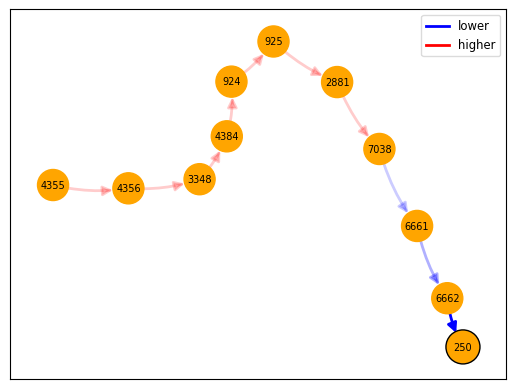

In [63]:
explanation.plot_graph()

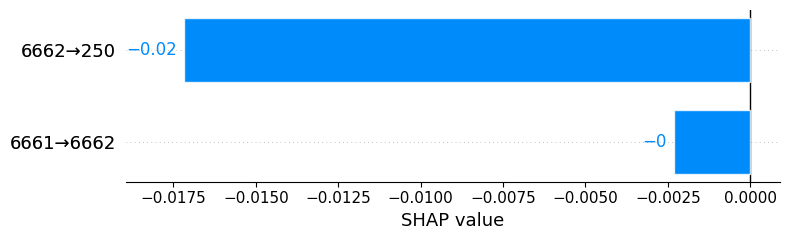

In [58]:
explanation.plot_bar(show=False)
plt.tight_layout()

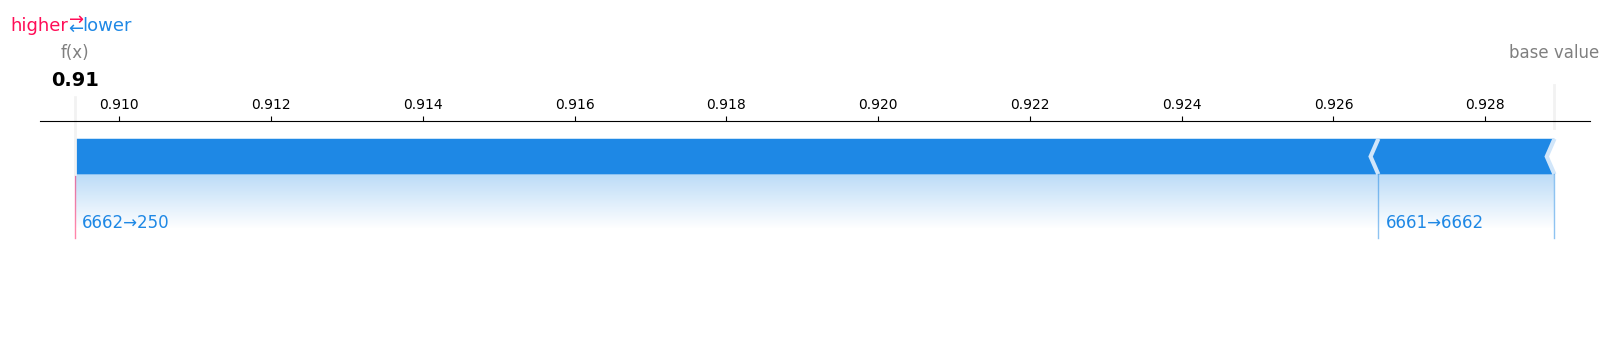

In [59]:
explanation.plot_force(show_values=False)